In [2]:
import pandas as pd
from IPython.display import display, HTML
%load_ext autoreload
%autoreload 2

import importlib

In [3]:
csv_file = open("uaScoresDataFrame.csv")
scores = pd.read_csv(csv_file)
scores = scores.drop('id', axis=1)
scores = scores.drop('Venture Capital', axis=1)

In [4]:
def check_zero(dataset):
    invalid_rows = []
    for element in dataset.columns.tolist():
        invalid = dataset[dataset[element] == 0.0]
        invalid_rows.append(invalid[['UA_Name','UA_Country']])
    df = pd.concat(invalid_rows).reset_index(drop=True).value_counts()
    return df
results = check_zero(scores).to_frame().reset_index().rename(columns={0:"number"})
print(results)

                       UA_Name               UA_Country  number
0                      Andorra                  Andorra       6
1                    Gibraltar                Gibraltar       5
2                      Managua                Nicaragua       3
3                     Tashkent               Uzbekistan       3
4                  Belize City                   Belize       3
5                       Panama                   Panama       3
6                    Palo Alto               California       2
7                       La Paz                  Bolivia       2
8                     Portland                    Maine       2
9                       Havana                     Cuba       2
10                     Fukuoka                    Japan       2
11                    San Juan              Puerto Rico       2
12                     Bozeman                  Montana       2
13                   Baltimore                 Maryland       2
14                    Valletta          

In [5]:
scores = scores[(scores != 0).all(1)]

In [6]:
weights_data = {
    'Housing' : 1.5,
    'Cost of Living' : 1.5,
    'Startups' : 0.5,
    'Business Freedom' : 0.8,
    'Safety' : 1.5,
    'Healthcare' : 1.5,
    'Education' : 0.5,
    'Travel Connectivity' : 1.5,
}

weights_vector = pd.Series(0.0, index=scores.columns[3:-1])
for i in range(len(weights_vector)):
    row_name = weights_vector.index[i]
    weights_vector[i] = weights_data.get(row_name, 1)

In [7]:
summable_values = list(scores)
if 'Naive Sum' in summable_values:
    summable_values.remove('Naive Sum')
weighted_scores = scores.copy()
weighted_scores = weighted_scores * weights_vector
scores['Naive Sum'] = weighted_scores[summable_values].sum(numeric_only=True, axis=1)

In [8]:
# scores['Naive Sum']
# better, worse

midpoint = scores['Naive Sum'].quantile()
scores['Label'] = ''
scores.loc[scores['Naive Sum'] < midpoint, 'Label'] = 'worse'
scores.loc[scores['Naive Sum'] >= midpoint, 'Label'] = 'better'

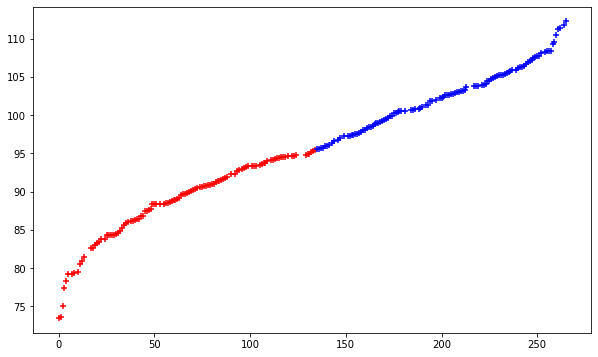

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
vals = scores['Naive Sum'].sort_values()
colors = np.where(vals >= midpoint, 'b', 'r')
ax.scatter(scores.index, vals, c=colors, marker='+')

In [10]:
from Modules.dataprocessing import ProcessingData

a, b = ProcessingData.prepare_data(scores)

preview_table = pd.concat([a.head(), b.head()])
display(preview_table)

,UA_Name,UA_Country,UA_Continent,Housing,Cost of Living,Startups,Travel Connectivity,Commute,Business Freedom,Safety,...,Education,Environmental Quality,Economy,Taxation,Internet Access,Leisure & Culture,Tolerance,Outdoors,Naive Sum,Label
0,Tbilisi,Georgia,Europe,0.943389,0.973889,0.238722,0.168295,0.817205,0.704022,0.942933,...,0.039355,0.234944,0.366874,0.773151,0.354176,0.435444,0.812314,0.669649,0.703272,better
1,Wroclaw,Poland,Europe,0.828000,0.826000,0.287333,0.167597,0.700961,0.404950,0.788078,...,0.397514,0.438437,0.429601,0.428155,0.546294,0.416611,0.289446,0.482309,0.522765,worse
2,Prague,Czechia,Europe,0.714500,0.729889,0.531056,0.515026,0.851302,0.475366,0.845145,...,0.405819,0.674330,0.382340,0.525717,0.584041,0.829389,0.812435,0.592089,0.979021,better
3,Rio De Janeiro,Brazil,South America,0.813333,0.750111,0.424778,0.086938,0.633272,0.173939,0.456536,...,0.056183,0.249446,0.112330,0.165559,0.153511,0.851944,0.516838,0.760393,0.101129,worse
4,Leipzig,Germany,Europe,0.797444,0.545667,0.189611,0.392186,0.879499,0.871497,0.685439,...,0.413256,0.906656,0.505022,0.288955,0.533100,0.391833,0.690031,0.571371,0.734543,better
188,Bogota,Colombia,South America,0.891944,0.897778,0.523167,0.129441,0.702520,0.494205,0.563565,...,0.112257,0.367393,0.409021,0.049627,0.226709,0.579444,0.855916,0.938652,0.451522,worse
189,Dusseldorf,Germany,Europe,0.586889,0.459333,0.265444,0.642535,0.756301,0.871497,0.788136,...,0.413256,0.715909,0.505022,0.288955,0.535337,0.407111,0.772243,0.653639,0.751681,better
190,Los Angeles,California,North America,0.058611,0.395111,1.000000,0.351562,0.485543,0.802558,0.503841,...,0.882043,0.411590,0.645634,0.389725,0.515890,0.910667,0.661592,0.840441,0.430683,worse
192,Cologne,Germany,Europe,0.614056,0.511889,0.456278,0.708275,0.772950,0.871497,0.610639,...,0.499783,0.612839,0.505022,0.288955,0.535337,0.480278,0.631326,0.644289,0.744118,better
193,Adelaide,Australia,Oceania,0.589944,0.410222,0.237389,0.117366,0.765279,0.916840,0.760411,...,0.503963,0.825857,0.590794,0.368848,0.383318,0.369833,0.766579,0.676846,0.566347,worse


In [15]:
import Modules.fuzzysys as fsys
from Modules.membership_functions import TriangularFunction
importlib.reload(fsys)

fuzzy = fsys.FuzzySystem()
fuzzy.add_antecedent('Housing', 'Bad', TriangularFunction(0, 0, 0.4))
fuzzy.add_antecedent('Housing', 'Mid', TriangularFunction(0.3, 0.4, 0.8))
fuzzy.add_antecedent('Housing', 'Good', TriangularFunction(0.7, 1, 1))

fuzzy.add_antecedent('Startups', 'Bad', TriangularFunction(0, 0, 0.3))
fuzzy.add_antecedent('Startups', 'Mid', TriangularFunction(0.2, 0.4, 0.6))
fuzzy.add_antecedent('Startups', 'Good', TriangularFunction(0.5, 0.8, 1))

fuzzy.add_rule({'Housing' : 'Bad', 'Startups': 'Bad', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Bad', 'Startups': 'Mid', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Bad', 'Startups': 'Good', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Mid', 'Startups': 'Bad', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Mid', 'Startups': 'Mid', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Mid', 'Startups': 'Good', 'Rating': 'Good'})
fuzzy.add_rule({'Housing' : 'Good', 'Startups': 'Bad', 'Rating': 'Good'})
fuzzy.add_rule({'Housing' : 'Good', 'Startups': 'Mid', 'Rating': 'Good'})
fuzzy.add_rule({'Housing' : 'Good', 'Startups': 'Good', 'Rating': 'Good'})

fuzzy.add_consequent('Rating', 'Bad', TriangularFunction(0, 0, 0.5))
fuzzy.add_consequent('Rating', 'Good', TriangularFunction(0.5, 1, 1))

for i in range(5):
    sample = a.iloc[i]
    result = fuzzy.compute(sample, 'fom')
    print(f'{sample["UA_Name"]} -> {result}')

crisp_result=1
Tbilisi -> Good
crisp_result=1
Wroclaw -> Good
crisp_result=1
Prague -> Good
crisp_result=1
Rio De Janeiro -> Good
crisp_result=1
Leipzig -> Good


In [12]:
import Modules.fuzzysys as fsys
from Modules.membership_functions import TrapezoidalFunction
importlib.reload(fsys)

fuzzy = fsys.FuzzySystem()
fuzzy.add_antecedent('Housing', 'Bad', TrapezoidalFunction(0, 0.2, 0.4, 0.6))
fuzzy.add_antecedent('Housing', 'Mid', TrapezoidalFunction(0.1, 0.3, 0.5, 0.7))
fuzzy.add_antecedent('Housing', 'Good', TrapezoidalFunction(0.3, 0.5, 0.7, 1))

fuzzy.add_antecedent('Startups', 'Bad', TrapezoidalFunction(0, 0.3, 0.6, 0.9))
fuzzy.add_antecedent('Startups', 'Mid', TrapezoidalFunction(0.1, 0.4, 0.7, 1))
fuzzy.add_antecedent('Startups', 'Good', TrapezoidalFunction(0.05, 0.25, 0.45, 0.65))

for i in range(5):
    sample = a.iloc[i].to_dict()
    fuzzified_sample = fuzzy.fuzzify(sample)
    print(f'{sample["UA_Name"]} -> {fuzzified_sample}')

Tbilisi -> {'Housing': {'linguistic': 'Good', 'numerical': 0.18870370370370348}, 'Startups': {'linguistic': 'Good', 'numerical': 0.9436111111111114}}
Wroclaw -> {'Housing': {'linguistic': 'Good', 'numerical': 0.5733333333333334}, 'Startups': {'linguistic': 'Good', 'numerical': 1}}
Prague -> {'Housing': {'linguistic': 'Good', 'numerical': 0.9516666666666664}, 'Startups': {'linguistic': 'Bad', 'numerical': 1}}
Rio De Janeiro -> {'Housing': {'linguistic': 'Good', 'numerical': 0.6222222222222221}, 'Startups': {'linguistic': 'Bad', 'numerical': 1}}
Leipzig -> {'Housing': {'linguistic': 'Good', 'numerical': 0.6751851851851852}, 'Startups': {'linguistic': 'Good', 'numerical': 0.6980555555555557}}
